# Second assignment: Analyse your "realistic" graph

## Load Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections, itertools
import networkx as nx

In [2]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

## Dataset Information

Arxiv GR-QC (General Relativity and Quantum Cosmology) collaboration network is from the e-print arXiv and covers scientific collaborations between authors papers submitted to General Relativity and Quantum Cosmology category. If an author i co-authored a paper with author j, the graph contains a undirected edge from i to j. If the paper is co-authored by k authors this generates a completely connected (sub)graph on k nodes.

The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv, and thus represents essentially the complete history of its GR-QC section.

<img src="images/arXivGraph.png" width="500">

### Dataset stats (from https://snap.stanford.edu/data/ca-GrQc.html)

<img src="images/dataset.png" width="300">

## Node level measurements

In [3]:
#Utils class
class statistics:
    
    def __init__(self, d, measure):
        self.measure = measure
        self.orderedList = sorted(list(d.items()), key=lambda pair: pair[1])
        self.orderedKeys = sorted(list(d.keys()))
        self.orderedValues = sorted(list(d.values()))
    
    def average(self):    
        return np.mean(self.orderedValues)

    def variance(self):
        return np.var(self.orderedValues)

    def maximum(self):
        return self.orderedList[-1]

    def minimum(self):
        return self.orderedList[0]

    def median(self):
        return self.orderedList[len(self.orderedList)//2]
    
    def print_info(self):
        print("{} distribution:\n\taverage: {}\n\tvariance: {}\n\tmaximum: {}\n\tminimum: {}\n\tmedian: {}\n"
              .format(self.measure,self.average(),self.variance(),
                      self.maximum(),self.minimum(),self.median()))
    
    def barplot(self):
        key, cnt = zip(*collections.Counter(self.orderedValues).items())

        plt.figure(figsize=(10,5))
        plt.bar(key, cnt, width=0.80, color='b')
        plt.title(self.measure+" barplot")
        plt.ylabel("Count")
        plt.xlabel(self.measure)
        plt.xticks(key, rotation=90)
        plt.tight_layout()
    
    def histogram(self, bins=10):
        plt.figure(figsize=(10,5))
        counts,bins,_ = plt.hist(self.orderedValues, bins=bins)
                                  
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):
            # Label the raw counts
            plt.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                         xytext=(0, -20), textcoords='offset points', va='top', ha='center')
            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            plt.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                         xytext=(0, -35), textcoords='offset points', va='top', ha='center')
        
        plt.title(self.measure+" histogram")
        plt.ylabel("Count")
        plt.xticks(bins)
        plt.show()

### Degree distribution
Provides the probability that a randomly selected node in the network has degree k:
$$p_{k} = \frac{N_{k}}{N}$$

<img src="images/measures/arXivDegree.png" width="500">

Degree distribution:
	average: 5.530713468141931
	variance: 62.70117419527453
	maximum: ('21012', 81)
	minimum: ('24372', 1)
	median: ('19454', 3)



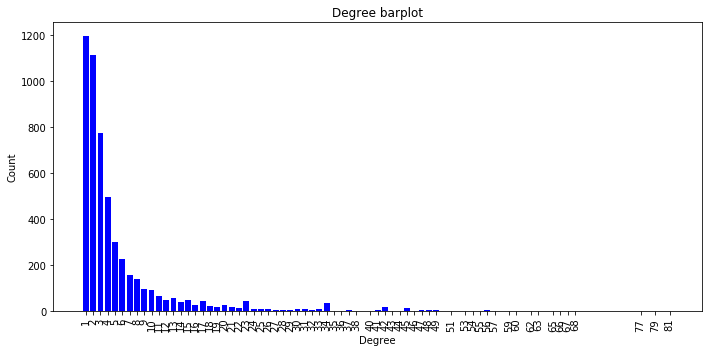

In [4]:
degree_stat = statistics(dict(G.degree),"Degree")
degree_stat.print_info()
degree_stat.barplot()

Looking at this histogram, we could observe that a fraction of nodes exist with very high degree; these presence of hubs that are orders of magnitude larger in degree than most nodes is a characteristic of **power law** networks.

We can also recognize that a degree distribution has a power-law form.

In fact for a random network we can state that the maximum degree node should have
$$k_{max}\approx\langle k\rangle+\langle k\rangle^{\frac{1}{2}}\;\text{[mean + stdev for a poisson distribution; 5+2.23 in the example]},$$
but we can observe many nodes with degree greater than 10 (646 out of 54242 exactly) with a peak of a node with 81 connections (this, in general, can confirm the power-law building rule for this network).

### Betweenness
Measures the extent to which a vertex lies on a path between other vertices.
$$B(v)=\sum_{s\neq v\neq t}\frac{\sigma_{st}(v)}{\sigma_{st}},$$
where $\sigma _{st}$ is the total number of shortest paths from node $s$ to node $t$ and $\sigma_{st}(v)$ is the number of those paths that pass through $v$.

<img src="images/measures/arXivBetweenness.png" width="500">

In [13]:
btwc = nx.betweenness_centrality(G)

Betweenness distribution:
	average: 0.0006062707858585127
	variance: 3.8989784331005185e-06
	maximum: ('13801', 0.03702715043389754)
	minimum: ('5233', 0.0)
	median: ('21594', 0.0)



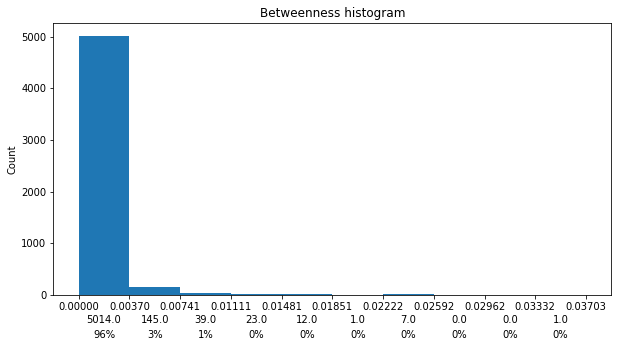

In [14]:
between_stat = statistics(btwc, "Betweenness")
between_stat.print_info()
between_stat.histogram()

There are few nodes with high betweenness which have a considerbale influence in a network (their removal may disrupt communication); this suggest that the newtork is scale-free with few hubs from which the majority of communication pass through.

### Closeness
Measure the mean distance of a vertex to other vertices.
$$C(x)={\frac{1}{\sum _{y}d(y,x)}},$$
where $d(y,x)$ is the geodesic distance between vertices $x$ and $y$.

<table>
    <tr>
        <td><img src="images/measures/arXivCloseness.png"></td>
        <td><img src="images/measures/arXivClosenessGiant.png"></td>
    </tr>
</table>


*N.B.*: In the case of a graph with more than one connected component, networkx library does not use the closeness centrality as defined above, but compute a variant of it (<i>Wasserman and Faust imporovement</i>):
$$C_{WF}(x)=\frac{n-1}{N-1}\cdot\frac{n-1}{\sum_{y}^{n-1}{d(y,x)}},$$
where $n$ is the number of nodes reached from $x$, while $N$ is the total number of nodes (in fact this version compute a size-scaled centrality measure).

In [15]:
clsn = nx.closeness_centrality(G)

Closeness distribution:
	average: 0.10630130466094839
	variance: 0.0032024611226696186
	maximum: ('13801', 0.19428463503141283)
	minimum: ('12295', 0.0)
	median: ('2607', 0.12792258161466954)



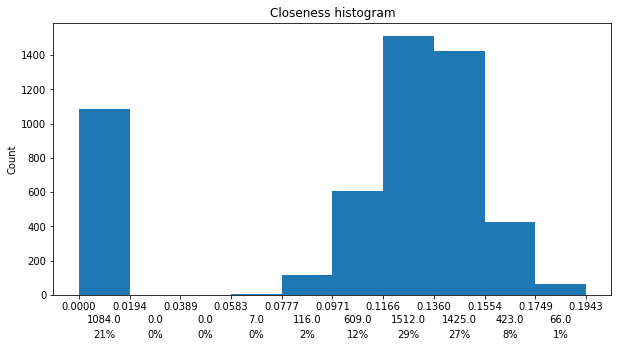

In [16]:
close_stat = statistics(clsn, "Closeness")
close_stat.print_info()
close_stat.histogram()

Nodes with high closeness have more direct influence on the other vertices; from this point of view we can easily tell the giant component apart from the periphery thanks to the Wasserman and Faust weighted centrality: nodes belonging to the connected component will have more influence on the graph dynamics (thus reflecting in a higher closeness) respect to the isolated clusters.

### Clustering
Coefficient that captures the density of links in node $i$'s immediate neighborhood.

<table>
    <tr>
        <td><img src="images/measures/arXivClustering.png"></td>
        <td><img src="images/measures/arXivTriangles.png"></td>
    </tr>
</table>

In [17]:
cl = nx.clustering(G)

Clustering distribution:
	average: 0.5296358110521362
	variance: 0.18376828591636982
	maximum: ('19521', 1.0)
	minimum: ('24372', 0)
	median: ('6971', 0.5)



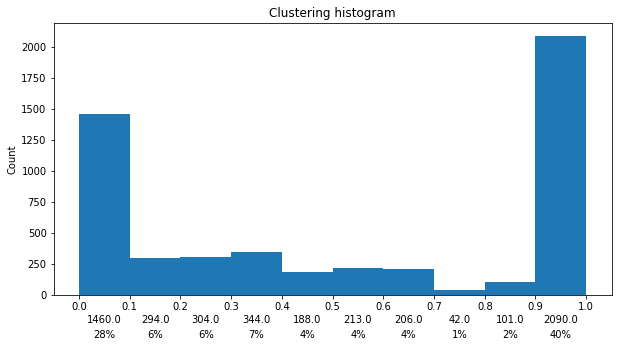

In [18]:
cluster_stat = statistics(cl, "Clustering")
cluster_stat.print_info()
cluster_stat.histogram()

Local clustering can be seen as an indicator of structural holes in the network: small values indicate powerful individuals.

From this plot we can observe that there is a big portion of nodes with clustering coefficient near 1 (strongly connected components) and another big number of nodes with coefficient near 0 (hubs).

This observation suggest again the our network is **scale-free**.

### Pagerank
High rank is assigned to those pages pointed by other important nodes (where the importance refers to the link structure within the network).

<img src="images/measures/arXivPagerank.png" width="500">

In [20]:
pgrnk = nx.pagerank_numpy(G)

Pagerank distribution:
	average: 0.0001907668828691339
	variance: 1.7611362331162616e-08
	maximum: ('14265', 0.0014427587831698954)
	minimum: ('4382', 3.797669433738513e-05)
	median: ('20116', 0.00016534502263061367)



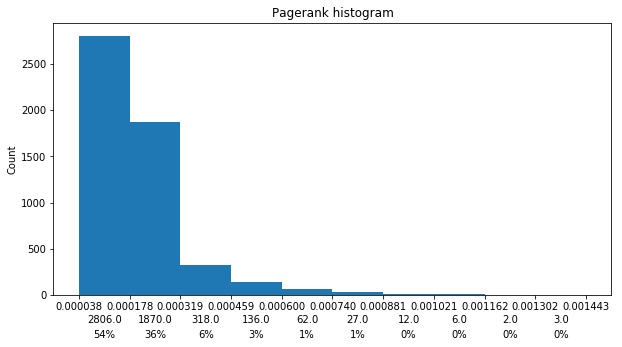

In [21]:
pagerank_stat = statistics(pgrnk, "Pagerank")
pagerank_stat.print_info()
pagerank_stat.histogram()

The function compute the PageRank algorithm with damping factor equal to 0.85 (like Google matrix).

### HITS (hubs = authorities)

<img src="images/measures/arXivHITS.png" width="500">    

In [22]:
hits = nx.hits_numpy(G)[0]

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  hubs = dict(zip(G, map(float, h)))
/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:208: ComplexWarning: Casting complex values to real discards the imaginary part
  authorities = dict(zip(G, map(float, a)))


HITS distribution:
	average: 0.000190766882869134
	variance: 2.6420454206524156e-06
	maximum: ('21012', 0.018432911493181284)
	minimum: ('16470', 0.0)
	median: ('8215', 2.731066165374546e-08)



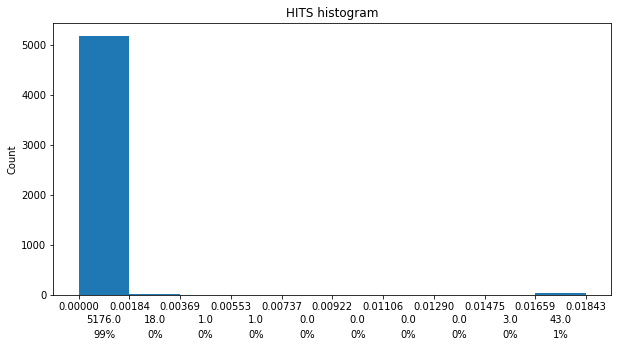

In [24]:
hits_stat = statistics(hits, "HITS")
hits_stat.print_info()
hits_stat.histogram()

**Emergence of hubs is a consequence of a scale-free property of networks. While hubs cannot be observed in a random network, they are expected to emerge in scale-free networks.<br>
 The existence of hubs is the biggest difference between random networks and scale-free networks. In random networks, the degree k is comparable for every node; it is therefore not possible for hubs to emerge. In scale-free networks, a few nodes (hubs) have a high degree k while the other nodes have a small number of links.**

## Graph level measurement

### Giant component


In [ ]:
G0 = max(nx.connected_component_subgraphs(G), key=len)

if(len(G)==len(G0)):
    print("Largest connected component covers the whole graph")
else:
    print("The Giant component covers the {}% of the whole graph".format(round(len(G0)/len(G)*100,2)))

Here the average degree distribution follow the intuition of the random network structure:
$$1<\langle k\rangle<\ln{(n)}\mapsto 1<5.53<8.56,$$
indeed we can observe a giant component [$1<\langle k\rangle$] and several not connected clusters [$\langle k\rangle<\ln{(n)}$].

### Community detection

In [30]:
from networkx.algorithms import community

**Girvan-Newman algorithm**
1. The betweenness of all existing edges in the network is calculated first.
2. The edge with the highest betweenness is removed.
3. The betweenness of all edges affected by the removal is recalculated.
4. Steps 2 and 3 are repeated until no edges remain.

In [31]:
communitiesGen_GW = community.girvan_newman(G)
top_GW = next(communitiesGen_GW)

In [32]:
communitiesGen_giantGW = community.girvan_newman(G0)
top_giantGW = next(communitiesGen_giantGW)

**Clauset-Newman-Moore greedy modularity maximization**

Greedy modularity maximization begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists.

modularity is calculated in this way<br>
Q = $\frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)$

In [33]:
communities_greedMod = community.greedy_modularity_communities(G)

In [34]:
communities_giantGreedMod = community.greedy_modularity_communities(G0)

### Communities evaluation

Evaluation of a possible graph partition is carried out keeping track of three possible measures:
<ol>
    <li><i>Coverage</i>: the ratio of the number of intra-community edges by the total number of edges: by definition, an ideal cluster structure, where the clusters are disconnected from each other, yields a coverage of 1, as all edges of the graph fall within clusters.</li>
    <li><i>Modularity</i>: is the fraction of the edges that fall within the given groups minus the expected fraction if edges were distributed at random. </li>
    <li><i>Performace</i>: counts the number of correctly “interpreted” pairs of vertices, i.e. two vertices belonging to the same community and connected by an edge, or two vertices belonging to different communities and not connected by an edge out of all the possible nodes pair. The definition of performance, for a partition
$p$, is:
$$P(p) = \frac{\#\{(i,j)\in E\;|\;C(i)=C(j)\}+\#\{(i,j)\notin E\;|\;C(i)\neq C(j)\}}{n(n−1)/2}.$$
    </li>
</ol>

In [35]:
def metric_evaluation(graph, communities, metric):
    return metric(graph, communities)

#### -- Girvan-Newman (betweenness)

In [36]:
metric_evaluation(G, top_GW, community.quality.coverage)

0.9998620309050773

In [37]:
metric_evaluation(G, top_GW, community.quality.modularity)

0.17641819590204016

In [38]:
metric_evaluation(G, top_GW, community.quality.performance)

0.3790116826789276

#### -- Clauset-Newman-Moore (greedy modularity)

In [39]:
metric_evaluation(G, communities_greedMod, community.quality.coverage)

0.9068018763796909

In [40]:
metric_evaluation(G, communities_greedMod, community.quality.modularity)

0.8132280211151603

In [41]:
metric_evaluation(G, communities_greedMod, community.quality.performance)

0.9374259144926121

### Communities visualisation

In [42]:
def display_communities(graph, comms):
    llist = [] # build a list of color for each community
    for node in graph:
        for i,comm in enumerate(comms):
            if node in comm:
                llist.append(i)
                break    
    vmax = len(np.unique(llist))-1
    
    plt.figure(figsize=(15,10))
    nx.draw_networkx(graph,node_color=llist,cmap = 'jet',vmin = 0,vmax=vmax,font_size=0,node_size=20)

#### -- Girvan-Newman (betweenness)

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


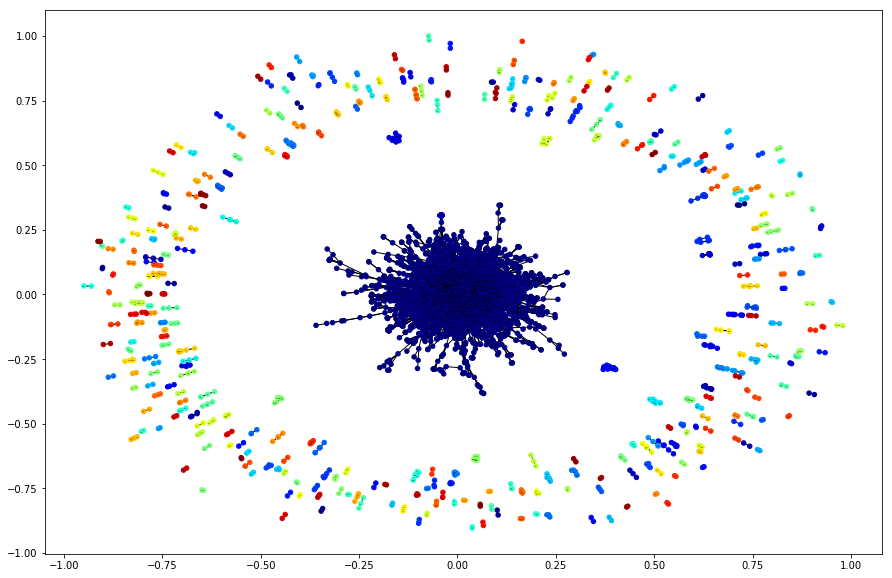

In [43]:
display_communities(G, top_GW)

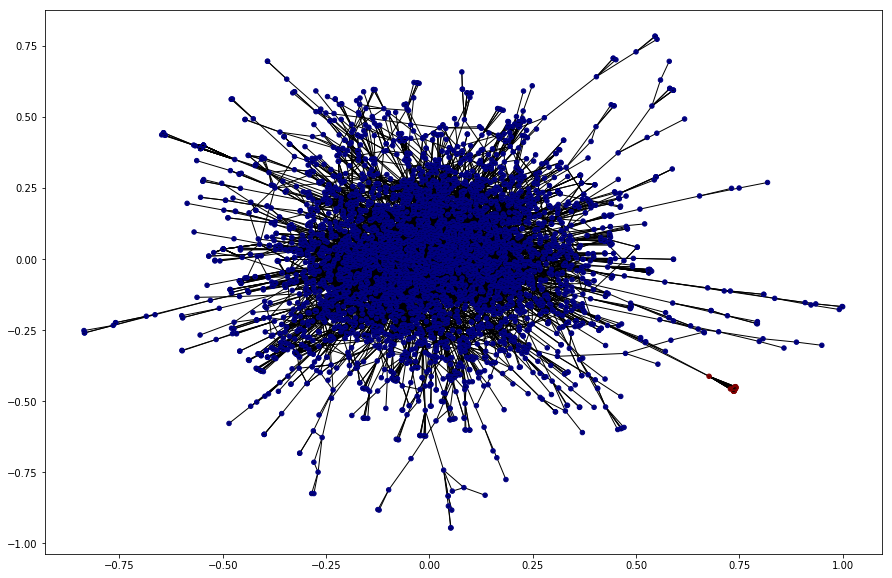

In [44]:
display_communities(G0, top_giantGW)

#### -- Clauset-Newman-Moore (greedy modularity)

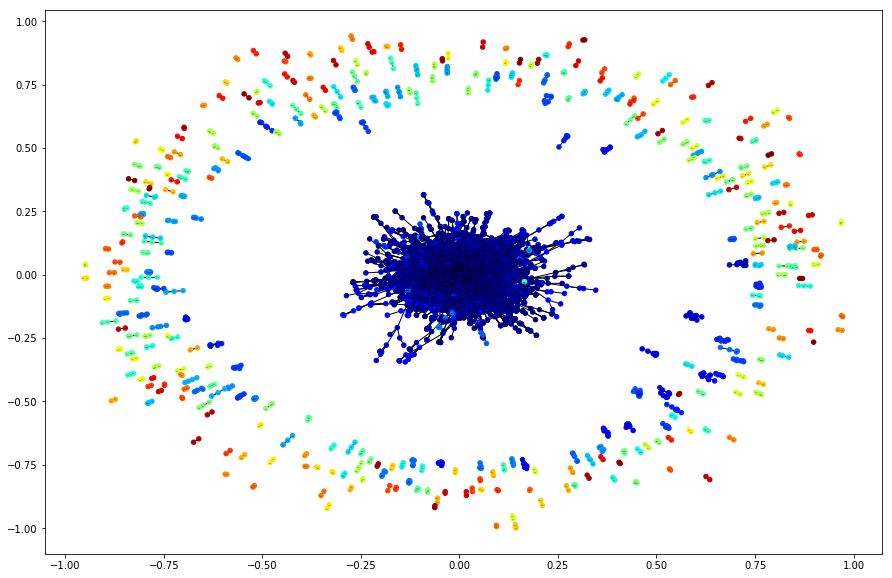

In [45]:
display_communities(G, communities_greedMod)

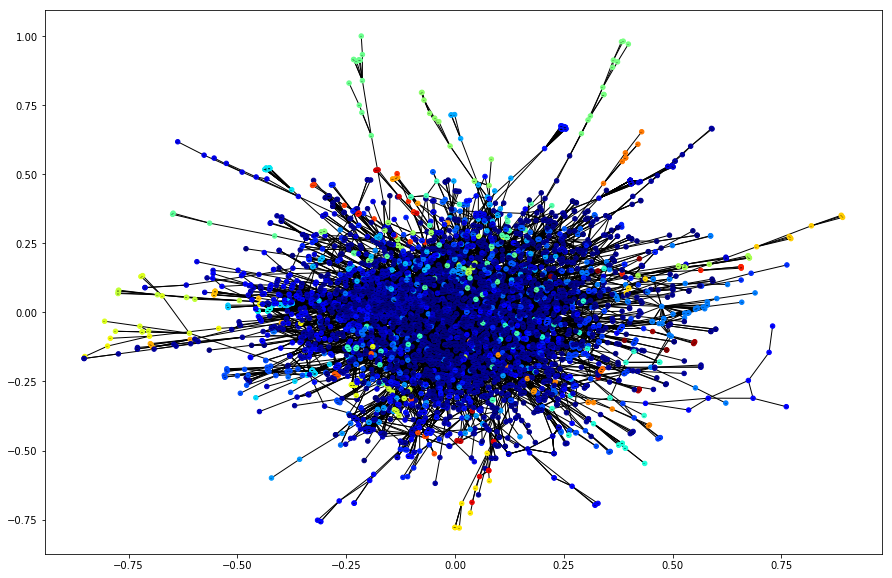

In [46]:
display_communities(G0, communities_giantGreedMod)

### Measures summary of the whole graph and giant component

#### -- general statistics of the whole graph

In [47]:
#Stats on the whole graph
density = nx.density(G)
avg_clust = nx.average_clustering(G)
trans = nx.transitivity(G)
assrt = nx.degree_pearson_correlation_coefficient(G)
diameter = float("Inf")
avg_path_lenght = float("Inf")
if(nx.is_connected(G)): # if is not connected we could not compute diameter and avg path length
    diameter = nx.diameter(G)
    avg_path_lenght = nx.average_shortest_path_length(G)

print("avg degree: ", degree_stat.average())
print("density: ", density)
print("diameter: ", diameter)
print("avg_path_lenght: ", avg_path_lenght)
print("avg_clustering coeff: ", avg_clust)
print("transitivity: ", trans)
print("assortativity: ", assrt)

avg degree:  5.530713468141931
density:  0.001055278280507905
diameter:  inf
avg_path_lenght:  inf
avg_clustering coeff:  0.5296358110521358
transitivity:  0.6298424741263426
assortativity:  0.6591640320931624


#### -- assortativity measures of the whole graph

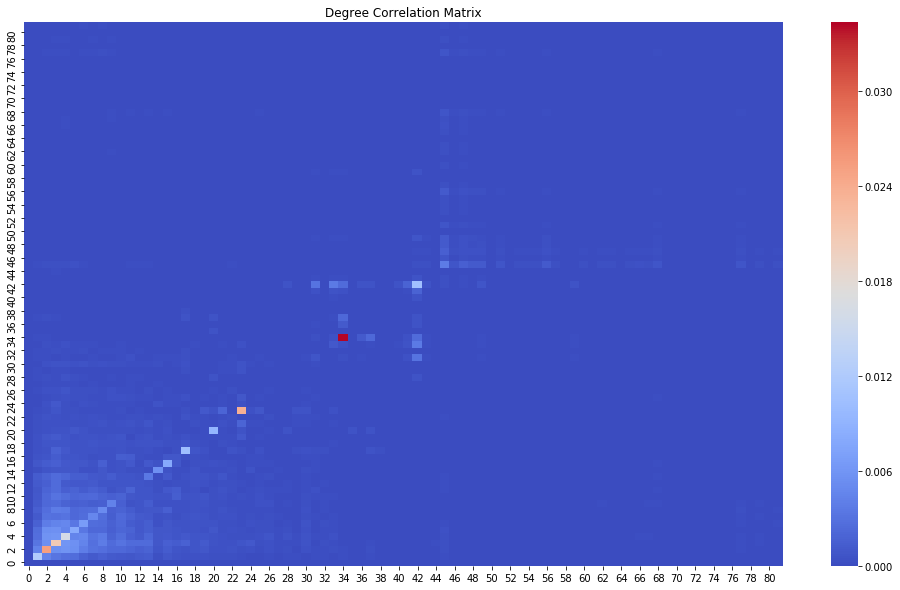

In [48]:
plt.figure(figsize=(17,10))
plt.title("Degree Correlation Matrix")
sns.heatmap(nx.degree_mixing_matrix(G), cmap="coolwarm").invert_yaxis();

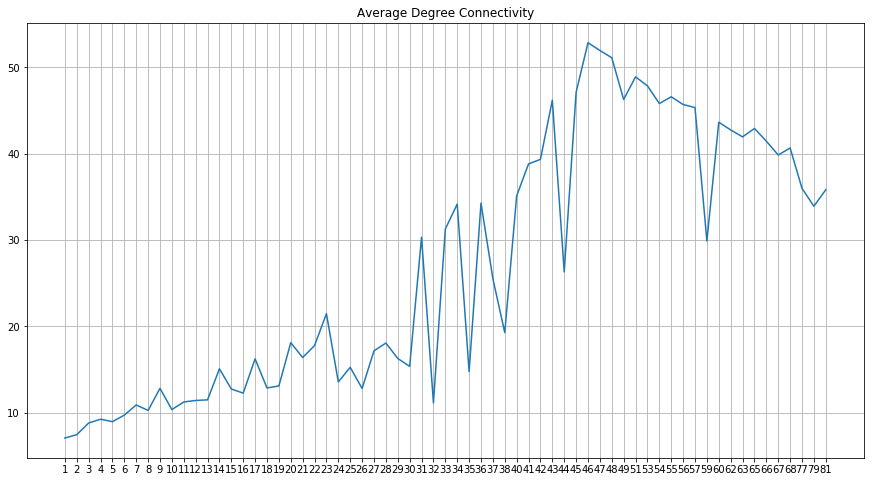

In [49]:
#plt.plot(nx.k_nearest_neighbors(G).values())
pairs = sorted(nx.k_nearest_neighbors(G).items(), key=lambda pair:pair[0])
plt.figure(figsize=(15,8))
plt.title("Average Degree Connectivity")
plt.plot(list(map(lambda pair:pair[1], pairs)))
plt.xticks(range(len(pairs)),list(map(lambda pair:pair[0], pairs)))
plt.grid()

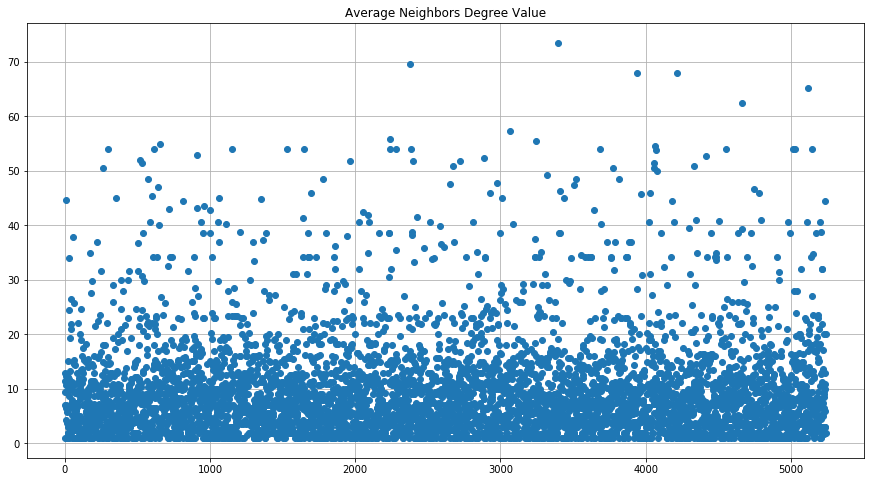

In [50]:
vals = list(map(lambda pair: pair[1], sorted(nx.average_neighbor_degree(G).items(), key=lambda pair:pair[0])))
plt.figure(figsize=(15,8))
plt.title("Average Neighbors Degree Value")
plt.plot(vals, 'o')
plt.grid()

#### -- general statistics of the giant component

In [51]:
# Stats on the Giant Component
degrees = [val for (node, val) in G0.degree]
avg_degree = sum(degrees)/len(degrees)

densityGiant = nx.density(G0)
diameterGiant = nx.diameter(G0)
transGiant = nx.transitivity(G0)
assrtGiant = nx.degree_pearson_correlation_coefficient(G0)
avg_path_lenghtGiant = nx.average_shortest_path_length(G0)
avg_clustGiant = nx.average_clustering(G0)

print("avg degree: ", avg_degree)
print("density: ", densityGiant)
print("diameter: ", diameterGiant)
print("avg_path_lenght: ", avg_path_lenghtGiant)
print("avg_clustering coeff: ", avg_clustGiant)
print("transitivity: ", transGiant)
print("assortativity: ", assrtGiant)

avg degree:  6.458874458874459
density:  0.0015537345342493286
diameter:  17
avg_path_lenght:  6.049380016182999
avg_clustering coeff:  0.5568782161697919
transitivity:  0.6288944756689877
assortativity:  0.6389971399620691


#### -- assortativity measures of the giant component

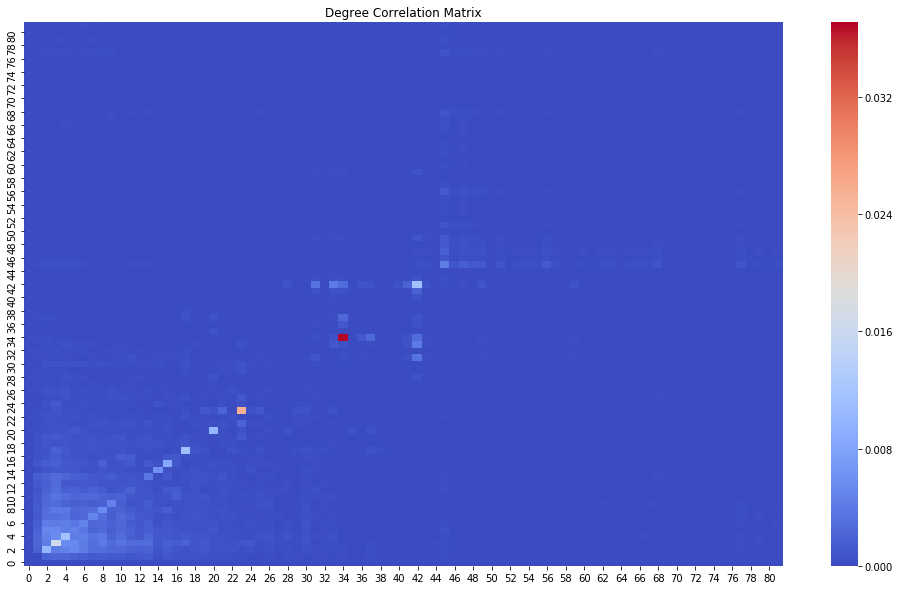

In [52]:
plt.figure(figsize=(17,10))
plt.title("Degree Correlation Matrix")
sns.heatmap(nx.degree_mixing_matrix(G0), cmap="coolwarm").invert_yaxis();

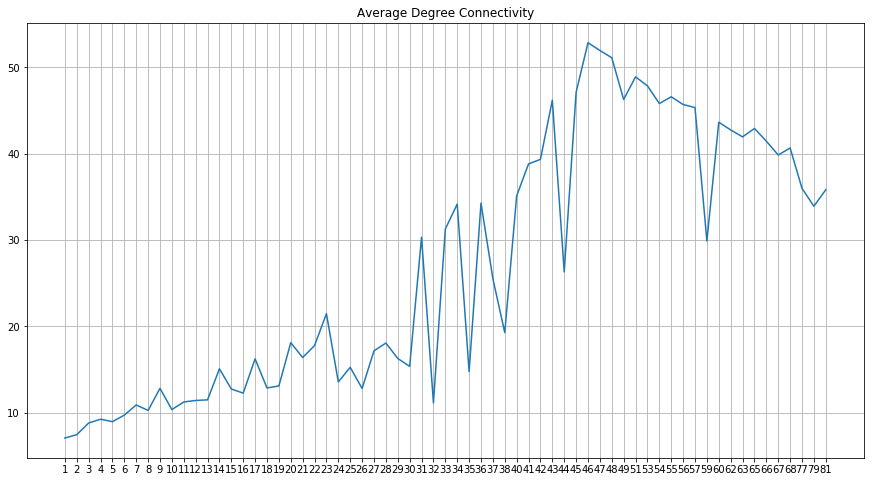

In [53]:
#plt.plot(nx.k_nearest_neighbors(G).values())
pairs = sorted(nx.k_nearest_neighbors(G).items(), key=lambda pair:pair[0])
plt.figure(figsize=(15,8))
plt.title("Average Degree Connectivity")
plt.plot(list(map(lambda pair:pair[1], pairs)))
plt.xticks(range(len(pairs)),list(map(lambda pair:pair[0], pairs)))
plt.grid()

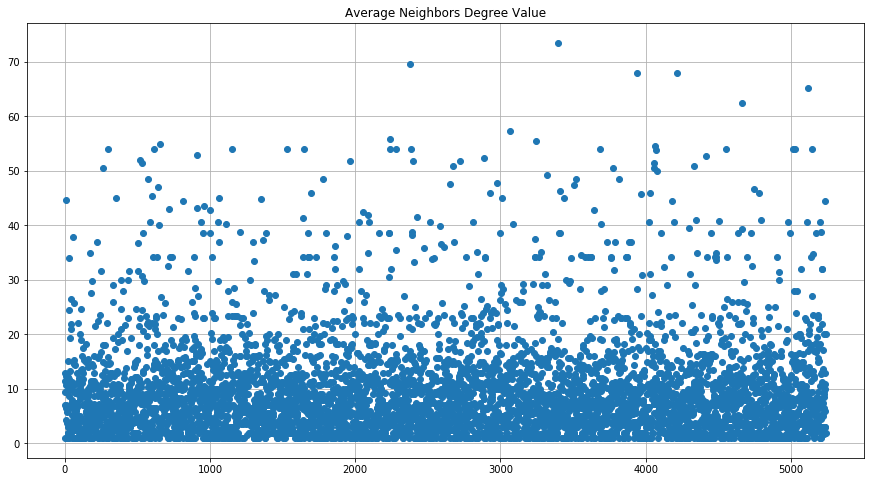

In [54]:
vals = list(map(lambda pair: pair[1], sorted(nx.average_neighbor_degree(G).items(), key=lambda pair:pair[0])))
plt.figure(figsize=(15,8))
plt.title("Average Neighbors Degree Value")
plt.plot(vals, 'o')
plt.grid()

### Direct question

**Does the graph have the same characteristics of a random or a power-law network?**<br>


In [55]:
from scipy.stats import poisson

def poisson_distr(average, peak, num):
    arr = []
    rv = poisson(average)
    for i in range(num+1):
        arr.append(rv.pmf(i)*4.5*peak)
        
    plt.plot(arr, 'r', linewidth=2.0)

def powerLaw_distr(peak, num):
    arr = []
    for i in range(1,num+2):
        arr.append(i**(-2.5)*peak)
        
    plt.plot(arr, 'r', linewidth=2.0)

##### -- Random graph testing

Transitivity: 0.6298424741263426
Clustering: 0.5296358110521358
Average degree: 5.530713468141931


False

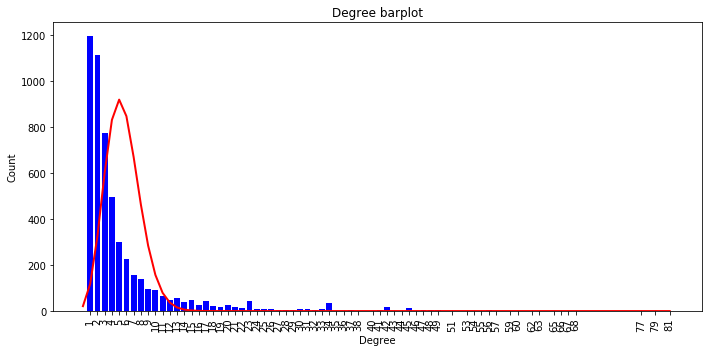

In [56]:
# Random graph has no transitivity or clustering
print("Transitivity: {}\nClustering: {}\nAverage degree: {}".format(trans, avg_clust, degree_stat.average()))

# Degree distribution
degree_stat.barplot()
poisson_distr(degree_stat.average(),
              max(collections.Counter(degree_stat.orderedValues).values()),
              degree_stat.maximum()[1])

# CONTROLLARE avg_degree > log N if true implies that these networks should be broken into isolated clusters
avg_degree > np.log(len(G))

##### -- Power-law distribution
As we seen in the graph below our graph behaves as a power law distribution; many nodes with only a few links, few hubs with large number of links

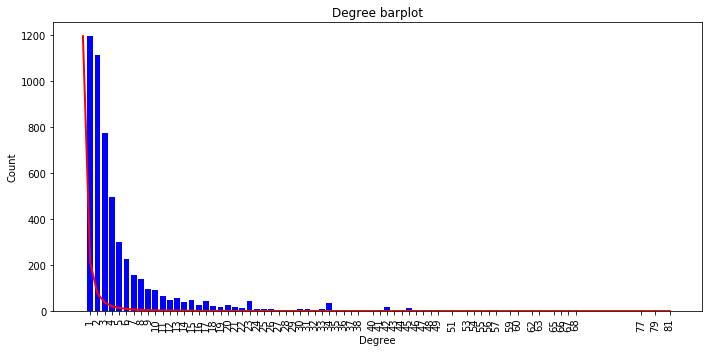

In [57]:
degree_stat.barplot()
powerLaw_distr(max(collections.Counter(degree_stat.orderedValues).values()),
              degree_stat.maximum()[1])

**Which are the most important nodes, with respect to a given centrality measure?**<br>


In [58]:
def most_important(graph, metric, top=10, index=None):
    if index is None:
        res = sorted(dict(metric(graph)).items(), key=lambda item:item[1], reverse=True)[:top]
    else:
        res = sorted(dict(metric(graph)[index]).items(), key=lambda item:item[1], reverse=True)[:top]
        
    return list(map(lambda pair:"{} ({})".format(pair[0],round(pair[1],2)), res))

In [59]:
display = 10

#degree
print("Best {} nodes in terms of degree are:\n{}\n"
      .format(display, most_important(G, nx.degree, top=display)))
#betweenness
print("Best {} nodes in terms of betweenness are:\n{}\n"
      .format(display, most_important(G, nx.betweenness_centrality, top=display)))
#Closeness
print("Best {} nodes in terms of closeness are:\n{}\n"
      .format(display, most_important(G, nx.closeness_centrality, top=display)))
#Clustering
print("Best {} nodes in terms of clustering are:\n{}\n"
      .format(display, most_important(G, nx.clustering, top=display)))
#Pagerank
print("Best {} nodes in terms of pagerank are:\n{}\n"
      .format(display, most_important(G, nx.pagerank_numpy, top=display)))

#HITS
print("Best {} nodes in terms of HITS are:\n{}\n"
      .format(display, most_important(G, nx.hits_numpy, top=display, index=0)))

Best 10 nodes in terms of degree are:
['21012 (81)', '21281 (79)', '22691 (77)', '12365 (77)', '6610 (68)', '9785 (68)', '21508 (67)', '17655 (66)', '2741 (65)', '19423 (63)']

Best 10 nodes in terms of betweenness are:
['13801 (0.04)', '9572 (0.03)', '14599 (0.03)', '7689 (0.02)', '13929 (0.02)', '5052 (0.02)', '14485 (0.02)', '2710 (0.02)', '14265 (0.02)', '17655 (0.02)']

Best 10 nodes in terms of closeness are:
['13801 (0.19)', '14485 (0.19)', '9572 (0.19)', '17655 (0.19)', '2654 (0.19)', '21012 (0.19)', '12545 (0.19)', '25006 (0.19)', '12365 (0.19)', '22691 (0.18)']

Best 10 nodes in terms of clustering are:
['5233 (1.0)', '18720 (1.0)', '14982 (1.0)', '24444 (1.0)', '16766 (1.0)', '16770 (1.0)', '16858 (1.0)', '17389 (1.0)', '495 (1.0)', '20008 (1.0)']

Best 10 nodes in terms of pagerank are:
['14265 (0.0)', '13801 (0.0)', '13929 (0.0)', '21281 (0.0)', '9572 (0.0)', '2710 (0.0)', '22691 (0.0)', '21012 (0.0)', '7689 (0.0)', '6264 (0.0)']

Best 10 nodes in terms of HITS are:
['2101

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  hubs = dict(zip(G, map(float, h)))
/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:208: ComplexWarning: Casting complex values to real discards the imaginary part
  authorities = dict(zip(G, map(float, a)))


**Are the paths short with respect to the size of the network?**<br>
if this ratio is near 0 it means that the short paths are much smaller than the network size; as opposite 
if the value is near 1 it means that the short path is similar to the longest minimum path (geodesic path)


In [60]:
avg_path_lenght/diameter

nan

**Is the network dense?**<br>


In [61]:
G.number_of_edges()*2.0/float(G.number_of_nodes()*(G.number_of_nodes()-1))

0.001055278280507905